**Preliminaries**

In [1]:
# import required packages
import pandas as pd

import numpy as np
import random

import time
from datetime import datetime

import torch
from torch import nn

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, random_split
from torchtext import data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve


In [2]:
# set seeds so that the results are reproducible

random.seed(22)
np.random.seed(22)

torch.backends.cudnn.deterministic = True
torch.manual_seed(22)
torch.cuda.manual_seed_all(22)

# set the device to GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available, Torch device is set to the available GPU")
else:
    device = torch.device("cpu")
    print("No GPU available, Torch device is set to CPU")

GPU available, Torch device is set to the available GPU


**Data Preprocessing and Vocabulary Building**

In [3]:
# make a pandas DataFrame from the text extracted with 1.Extraction.ipynb
extracted_text = pd.read_csv("https://anti-phish.s3.eu-west-1.amazonaws.com/dataset/extracted/extracted_text.csv", keep_default_na=False, index_col=0)

In [4]:
# preview the data in the DataFrame
extracted_text

,phishing,header,text
0,0,"Status: RO\nFrom: ""Lynton, Michael"" <MAILER-DA...",Re: i may have a meeting around 3pm i have to ...
1,0,"Status: RO\nFrom: ""Mosko, Steve"" <MAILER-DAEMO...",RE: Mosko's Calls a/o 5:55pm Tues 3/4 - 2 new ...
2,0,Received: from domain.com (146.215.230.105) by...,[domain.com] 'Phillips' IS The Captain Now As ...
3,0,Received: from domain (192.168.10.251) by doma...,Trump: Leave It To Me To be automatically unsu...
4,0,Received: from domain ([fe80::f85f:3b98:e405:6...,EVENT: Trump and Clinton video remarks to Lati...
...,...,...,...
14383,1,Return-Path: admin@ordnungswelt.net\nDelivered...,Account suspension notice 12/09/2020 03:36:33 ...
14384,1,Return-Path: MAILER-DAEMON\nDelivered-To: jose...,Undeliverable: Delivery Status Notification (F...
14385,1,Return-Path: reply@c.constantcontact.com\nDeli...,Reminder: Notice for monkey.org \n\n\n\r\nDear...
14386,1,Return-Path: amit@aonenonwoven.com\nDelivered-...,Notification jose@monkey.org \n\n\n \nDear jos...


In [5]:
# instantiate a basic english tokenizer to convert email text content into tokens
tokenizer = get_tokenizer('basic_english')

# create a custom torch.Dataset class that will store our text and labels
# to be fed into the neural network with the torch.DataLoader class

# our CustomEmailDataset inherits all the attributes of its parent class Dataset
class CustomEmailDataset(Dataset):
    def __init__(self, email_texts, labels):
        # each email's text will be tokenized when it is passed to the constructor upon instantiation
        self.tokens = [tokenizer(text) for text in email_texts]
        # phishing labels are already in the correct integer format
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # return a specific text-tokens and label pair
        return self.tokens[idx], self.labels[idx]

In [6]:
# split into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(extracted_text['header'] + "\n" + extracted_text['text'], extracted_text['phishing'], test_size=0.2, random_state=22)

# instantiate an instance of the CustomEmailDataset class for the training data
# this will call the __init__ constructor on the text and labels
train_dataset = CustomEmailDataset(X_train.values, y_train.values)

# instantiate an instance of the CustomEmailDataset for the test data
test_dataset = CustomEmailDataset(X_test.values, y_test.values)

In [7]:
# show the stored tokens and label stored for an example email
# accessing an idx of the dataset calls the __getitem__ function
print("Email 357's Tokens:\n", train_dataset[357][0])
print("Email 357's Phishing Label:\n", train_dataset[357][1])

Email 357's Tokens:
 ['received', 'from', 'domain', '(', '[fe80', 'f85f', '3b98', 'e405', '6ebe]', ')', 'by', 'domain', '(', '[', '1]', ')', 'with', 'mapi', 'id', '14', '.', '03', '.', '0224', '.', '002', 'tue', ',', '3', 'may', '2015', '18', '41', '40', '-0400', 'from', 'nordyke', ',', 'hannah', '<user@domain>', 'to', 'user', '<user@domain>', ',', 'comm_d', '<user@domain>', 'subject', 're', 'video', 'requst', 'fox', 'business', 'coverage', 'thread-topic', 'video', 'requst', 'fox', 'business', 'coverage', 'thread-index', 'adglip4oxp9ln/vpqxqny9o07otsgqaa9f4w', 'date', 'tue', ',', '3', 'may', '2015', '15', '41', '39', '-0700', 'message-id', '<user@domain>', 'references', '<user@domain>', 'in-reply-to', '<user@domain>', 'accept-language', 'en-us', 'content-language', 'en-us', 'x-ms-exchange-organization-authas', 'internal', 'x-ms-exchange-organization-authmechanism', '04', 'x-ms-exchange-organization-authsource', 'domain', 'x-ms-has-attach', 'x-auto-response-suppress', 'dr', ',', 'oof', 

In [8]:
# build a vocabulary from the tokens found in the training dataset
# by iterating over all tokens in the train_dataset, torchtext's build_vocab_from_iterator
# assigns an integer the first time a token is seen more than the minimum frequency

# words that occur less than min_freq times are assigned '<unk>'
min_freq = 3

vocab = build_vocab_from_iterator(train_dataset.tokens,
                                                  min_freq=min_freq,
                                                  specials=["<UNK>", "<PAD>"])

vocab.set_default_index(vocab["<UNK>"])

In [9]:
# show that the default token is assigned index 0
# any other special tokens are found at the beginning of the vocab
print("Token at index 0: ", vocab.lookup_token(0))
print("Token at index 1: ", vocab.lookup_token(1))

# show an example of how a token has been assigned an index
print("Token assigned the index of 300: ", vocab.lookup_token(300))

Token at index 0:  <UNK>
Token at index 1:  <PAD>
Token assigned the index of 300:  x-spam-status


**Deep Learning Model: Long Short Term Memory Classifier**

In [10]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_class):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_layer = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_class)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden, carry = torch.randn(self.num_layers, len(X_batch), self.hidden_dim).to(device), torch.randn(self.num_layers, len(X_batch), self.hidden_dim).to(device)
        output, (hidden, carry) = self.lstm(embeddings, (hidden, carry))
        return self.linear(output[:,-1])

In [11]:
# redefine model training and evaluation functions as LSTM does not use offsets

def train_lstm(model, dataloader):
    # set model training mode to use per-batch statistics and activate Dropout layers
    model.train()

    # cycle through each batch of data in the dataloader
    # dataloader applied the embedding_bag_processing function to each batch
    for (texts, labels) in tqdm(dataloader):
        # clear old gradients before next backward pass
        optimizer.zero_grad()

        # use the model to predict the phishing labels for this batch's emails
        predicted_labels = model(texts)

        # use the predicted_label and actual labels to compute
        # the loss according to the criterion's loss function
        loss = criterion(predicted_labels, labels)

        # calculate the gradients of the entire network based on the loss
        # gradient is stored in the .grad attribute of each tensor with required_grad=True
        loss.backward()

        # clips the normal of all gradients, to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        # optimizer iterates over the parameters it is optimizing and
        # uses the .grad calculated previously to update the parameter values
        optimizer.step()

def evaluate_lstm(model, dataloader):
    # set eval mode to enable running statistics and disable Dropout layer
    model.eval()

    # initialise counter variables at 0 where accuracy and total count will be added to after each batch
    accurate_count, total_count = 0, 0

    # disable gradient computation
    with torch.no_grad():

        for (text, labels) in dataloader:
            # calculate this batch's predicted_labels
            predicted_labels = model_lstm(text)

            loss = criterion(predicted_labels, labels)

            # count how many predicted_labels match the actual labels
            accurate_count += (predicted_labels.argmax(1) == labels).sum().item()

            # count how many total labelled emails in this batch
            total_count += labels.size(0)

    return loss, accurate_count/total_count

def get_predicted_labels(model, dataloader):
    model.eval()

    with torch.no_grad():
        predicted_labels = []
        for (text, labels) in dataloader:
            # calculate this batch's predicted_labels
            output = model(text)
            output = [tensor.item() for tensor in output.argmax(1)]
            predicted_labels.extend(output)

    return predicted_labels

In [12]:
# function used by the DataLoader to format input data
def RNN_processing(batch):
    texts_vector, labels_vector = [], []

    # calculate the longest length email in this batch
    max_length = max([len(tokens) for tokens, labels in batch])

    for tokens, label in batch:

        # for each email in the batch, create a vector from the integers assigned to the tokens' in the vocabulary
        tokens_vector = torch.tensor(vocab(tokens), dtype=torch.int64)

        # create a vector of 1's of the same length as the longest text in this batch
        padded_vector = torch.ones(max_length, dtype=torch.int64)

        # overwrite the beginning of the padded_vector with the tokens_vector
        padded_vector[0:len(tokens_vector)] = tokens_vector

        # append the padded tokenz vector of this email to this batch's list
        texts_vector.append(padded_vector)

        # append this email's phishing label to this batch's labels_list
        labels_vector.append(label)

    # convert the list of label integers to a single vector
    labels_vector = torch.tensor(labels_vector, dtype=torch.int64)

    return torch.stack(texts_vector).to(device), labels_vector.to(device)

In [13]:
# instantiation of Long Short Term Memory model
model_lstm = LSTMClassifier(vocab_size=len(vocab), embed_dim=64, hidden_dim=75, num_layers=1, num_class=2).to(device)

# declaration of hyperparameters
EPOCHS = 10 # epoch
LR = 1e-3  # learning rate
BATCH_SIZE = 4 # batch size for training
total_accu = None

# this criterion will be used to compute the cross entropy loss between input and target
criterion = torch.nn.CrossEntropyLoss()

# optimise parameters in order to implement adapted moment estimation, an optimised stochastic gradient descent
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=LR)

# StepLR scheduler will decay the learning rate by gamma every step_size epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

# isolate a small 5% validation set
valid_size = int(len(train_dataset) * 0.05)

split_valid, split_train  = random_split(train_dataset, [valid_size, len(train_dataset) - valid_size])

# instantiate PyTorch DataLoaders using our previously defined parameters
train_dataloader = DataLoader(split_train, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=RNN_processing)
valid_dataloader = DataLoader(split_valid, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=RNN_processing)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, collate_fn=RNN_processing)

In [14]:
total_accuracy = None

# loop through epochs, calling train() and evaluate()
for epoch in range(1, EPOCHS + 1):

    # set time to measure training time
    epoch_start_time = time.time()
    print('Epoch %d Start:' % epoch)

    # pass the train_dataloader to the train function previously defined
    train_lstm(model_lstm, train_dataloader)
    # calculate the accuracy of the model on the validation dataset
    loss, valid_accuracy = evaluate_lstm(model_lstm, valid_dataloader)

     # compare accuracies to check whether to adjust learning rate
    if total_accuracy is not None and total_accuracy > valid_accuracy:
        scheduler.step()
    else:
        total_accuracy = valid_accuracy

    # print epoch results
    print(' \t Validation Loss {:.4f} |  Validation Accuracy {:.4f} | '
          ' Training Time: {:.4f} s '.format(loss, valid_accuracy, time.time() - epoch_start_time))

Epoch 1 Start:


100%|██████████| 2734/2734 [00:21<00:00, 125.84it/s]


 	 Validation Loss 0.0003 |  Validation Accuracy 0.9791 |  Training Time: 22.2191 s 
Epoch 2 Start:


100%|██████████| 2734/2734 [00:20<00:00, 133.64it/s]


 	 Validation Loss 0.0006 |  Validation Accuracy 0.9791 |  Training Time: 20.9758 s 
Epoch 3 Start:


100%|██████████| 2734/2734 [00:21<00:00, 124.85it/s]


 	 Validation Loss 0.0005 |  Validation Accuracy 0.9861 |  Training Time: 22.4107 s 
Epoch 4 Start:


100%|██████████| 2734/2734 [00:21<00:00, 127.62it/s]


 	 Validation Loss 0.0003 |  Validation Accuracy 0.9913 |  Training Time: 21.9245 s 
Epoch 5 Start:


100%|██████████| 2734/2734 [00:20<00:00, 134.44it/s]


 	 Validation Loss 0.0000 |  Validation Accuracy 0.9948 |  Training Time: 20.8490 s 
Epoch 6 Start:


100%|██████████| 2734/2734 [00:21<00:00, 128.50it/s]


 	 Validation Loss 0.0000 |  Validation Accuracy 0.9948 |  Training Time: 21.7976 s 
Epoch 7 Start:


100%|██████████| 2734/2734 [00:21<00:00, 126.59it/s]


 	 Validation Loss 0.0000 |  Validation Accuracy 0.9965 |  Training Time: 22.1233 s 
Epoch 8 Start:


100%|██████████| 2734/2734 [00:20<00:00, 134.45it/s]


 	 Validation Loss 0.0000 |  Validation Accuracy 0.9948 |  Training Time: 20.8382 s 
Epoch 9 Start:


100%|██████████| 2734/2734 [00:20<00:00, 130.74it/s]


 	 Validation Loss 0.0000 |  Validation Accuracy 0.9948 |  Training Time: 21.4190 s 
Epoch 10 Start:


100%|██████████| 2734/2734 [00:21<00:00, 125.25it/s]


 	 Validation Loss 0.0000 |  Validation Accuracy 0.9948 |  Training Time: 22.3307 s 


In [15]:
loss, accuracy = evaluate_lstm(model_lstm, test_dataloader)
print("LSTM Classifier's Test Dataset Accuracy:", accuracy)

LSTM Classifier's Test Dataset Accuracy: 0.9986101459346769


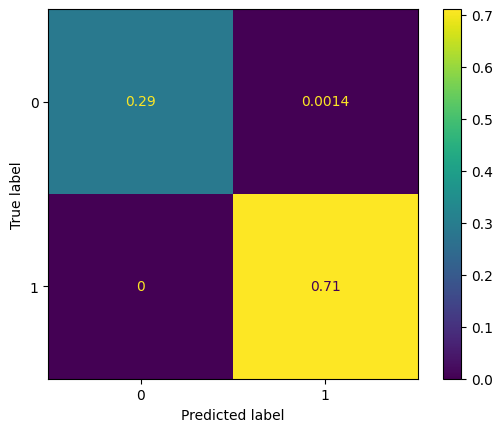

In [16]:
# calculate the model's prediction labels of the test data
y_pred_lstm = get_predicted_labels(model_lstm, test_dataloader)

# create a normalised confusion matrix comparing predictions to actual y_test values
cm_lstm = confusion_matrix(y_test, y_pred_lstm, normalize='all')

# plot confusion matrix
ConfusionMatrixDisplay(cm_lstm).plot()

Confusion Matrix shows that:





*   of the 29% non-phishing emails in the test dataset, 0.0014% of the model's predictions classified them as phishing.
*   of the 70% phishing emails in the test dataset, none of the model's predictions classified them as non-phishing



In [17]:
# # save/output the model for later use
# torch.save(model_lstm.state_dict(), "/content/drive/MyDrive/Models/" + 'LSTM ' + str(datetime.now()) + '.pt')

**Generalisable Accuracy on No-Header Dataset**

In [18]:
# make a pandas DataFrame from the text extracted with 1.Extraction.ipynb
extracted_text_no_header = pd.read_csv("https://anti-phish.s3.eu-west-1.amazonaws.com/dataset/extracted/extracted_text_no_header.csv", keep_default_na=False, index_col=0)

In [19]:
X_no_header = extracted_text_no_header['text']
y_no_header = extracted_text_no_header['phishing']

# create new test dataset of IWSPA No Header Emails
test_dataset_no_header = CustomEmailDataset(X_no_header.values, y_no_header.values)

In [20]:
# show an example of one of the emails
X_no_header[0]

'  Thank you for your reply, the local NSM response was not as kind. I am eager to learn and am greatful for your kindness. I want to be a part of the party; I can offer my artistic ability in the fashion of classic oil painting like that of Durer but am not as interested in design. \nwith greatfullness. \nZachary Young\n'

In [21]:
# instantiate a dataloader to test our trained model's accuracy on these previously unseen no-header emails
test_dataloader_no_header = DataLoader(test_dataset_no_header, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=RNN_processing)

# calculate the accuracy on the unfamiliar dataset
print("LSTM generalisable accuracy:", evaluate_lstm(model_lstm,test_dataloader_no_header)[1])

LSTM generalisable accuracy: 0.8456563537843035
